# load library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from catboost import cv, Pool

plt.rcParams['font.family'] = 'Malgun Gothic'

# load data

In [2]:
combined_df= pd.read_csv('preprocessed data/combined_df.csv',index_col=0)
combined_df.drop(['RESPOND_ID','EXAMIN_BEGIN_DE'],axis=1,inplace=True)
combined_df

,SEX,AGE,AREA,INCOME,SEOUL,GYEONGGI,BUSAN,CHUNGNAM,CHUNGBUK,GYEONGNAM,...,Shopping,Activity,Etc,City,District,Company,Per_Diem,Married,Children,Occupation
0,F,50대,서울특별시,300이상500만원 미만,4,3,3,3,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,50대,서울특별시,700만원 이상,3,4,3,3,3,3,...,1만원 미만,1만원 미만,3~5만원 미만,경기도,이천시,2명,1박 2일,기혼,자녀 성인(막내 대학),사무/기술직
2,F,50대,서울특별시,300만원 미만,3,3,4,3,3,3,...,1만원 미만,1만원 미만,1만원 미만,강원도,홍천군,2명,1박 2일,기혼,자녀 성인(막내 대학),판매/서비스직
3,F,50대,서울특별시,500이상700만원 미만,3,3,5,3,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F,50대,서울특별시,300이상500만원 미만,4,3,3,3,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19538,F,20대,충청남도(세종시 포함),모름,1,1,1,4,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19539,F,20대,경기도,모름,3,3,3,3,2,3,...,모름,모름,모름,제주도,구체적인 지역 모름,2명,3박 4일,기혼,신혼기(자녀 없음),판매/서비스직
19540,F,60대,경기도,500이상700만원 미만,3,4,2,3,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19541,F,50대,경기도,700만원 이상,3,5,4,3,4,4,...,10만원 이상,5~7만원 미만,1만원 미만,제주도,서귀포시(시내동)/애월읍/제주시(시내동),5명 이상,2박 3일,기혼,자녀 성인(막내 대학),사무/기술직


# data preprocessing

In [3]:
# 제주 여행 기대치가 4 또는 5인 그룹 인덱싱
jeju_df = combined_df[(combined_df['JEJU']==5) | (combined_df['JEJU']==4)]

# 서울특별시, 경기도, 인천광역시 시민 인덱싱
jeju_df = jeju_df[(jeju_df['AREA']=='서울특별시')]

# 소득구간 '700만원 이상' 제외
jeju_df = jeju_df[jeju_df['INCOME']!='700만원 이상']
jeju_df


,SEX,AGE,AREA,INCOME,SEOUL,GYEONGGI,BUSAN,CHUNGNAM,CHUNGBUK,GYEONGNAM,...,Shopping,Activity,Etc,City,District,Company,Per_Diem,Married,Children,Occupation
2,F,50대,서울특별시,300만원 미만,3,3,4,3,3,3,...,1만원 미만,1만원 미만,1만원 미만,강원도,홍천군,2명,1박 2일,기혼,자녀 성인(막내 대학),판매/서비스직
15,F,30대,서울특별시,500이상700만원 미만,3,3,4,3,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,F,30대,서울특별시,500이상700만원 미만,4,1,4,3,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,M,20대,서울특별시,300이상500만원 미만,5,3,5,4,4,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,M,20대,서울특별시,500이상700만원 미만,2,2,4,3,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19304,F,50대,서울특별시,300이상500만원 미만,3,2,3,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19317,F,30대,서울특별시,500이상700만원 미만,3,2,4,2,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19365,M,20대,서울특별시,300만원 미만,2,5,5,5,5,1,...,1만원 미만,1만원 미만,5~7만원 미만,강원도,강릉시/고성군/동해시/삼척시/속초시/양구군/영월군/원주시/인제군/정선군/철원군/태백...,혼자서,모름,미혼,미혼,자영업
19400,F,60대,서울특별시,300만원 미만,3,3,4,3,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

C:\Users\top\AppData\Local\Temp\ipykernel_13456\2303788261.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_labels, y=age_sizes, ax=axs[0, 1], palette='pastel')
C:\Users\top\AppData\Local\Temp\ipykernel_13456\2303788261.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='INCOME', data=jeju_df, ax=axs[1, 1], palette='pastel', order = income_order)


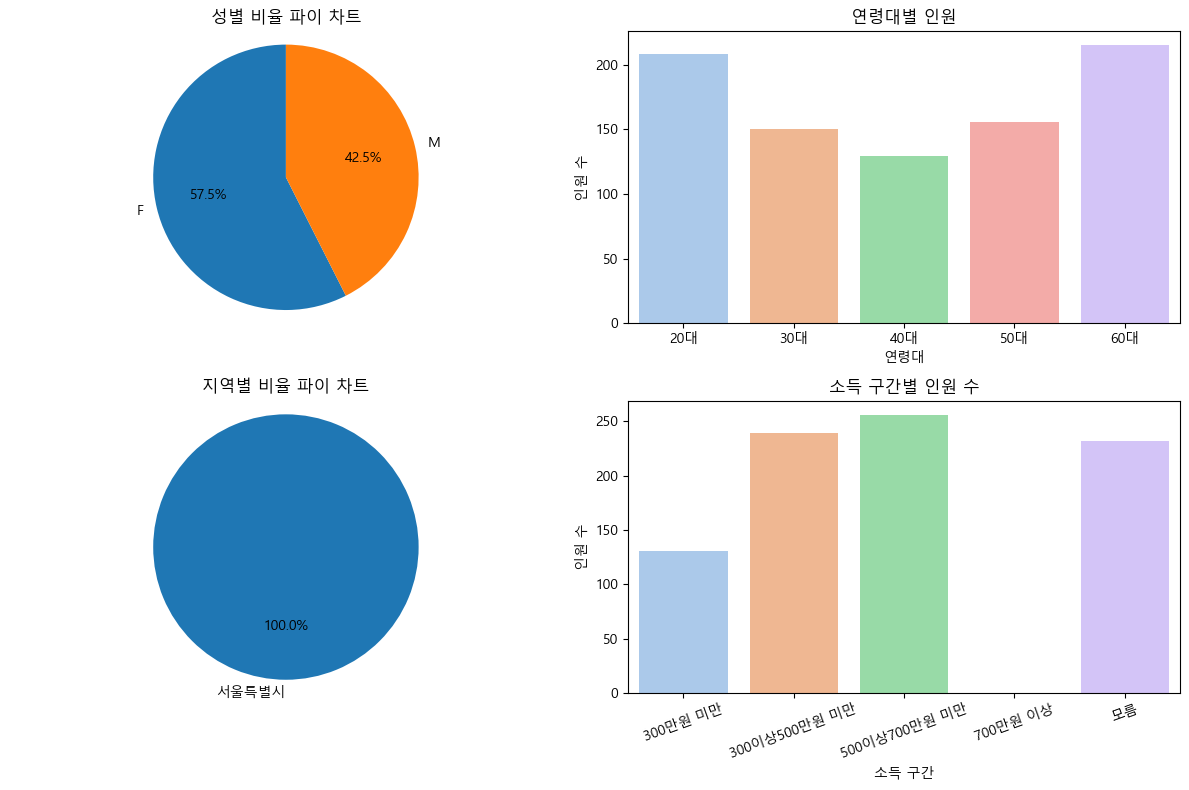

In [4]:
# 1. 성별 인원수 계산 (Pie Chart)
sex_counts = jeju_df['SEX'].value_counts()
sex_labels = sex_counts.index
sex_sizes = sex_counts.values

# 2. 연령대 인원수 계산 (Bar Plot)
age_counts = jeju_df['AGE'].value_counts().sort_index()  # 정렬
age_labels = age_counts.index
age_sizes = age_counts.values

# 3. 지역(AREA)별 인원수 계산 (Pie Chart)
area_counts = jeju_df['AREA'].value_counts()
area_labels = area_counts.index
area_sizes = area_counts.values

# 4. 소득(INCOME)별 인원수 (Countplot)
# (sns.countplot은 따로 value_counts 안 해도 되지만, 정렬이 필요하면 .sort_index() 활용)
# jeju_df['INCOME']이 카테고리형/문자형이라면 그대로 countplot 사용 가능

# 2x2 subplot 생성
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# [0, 0] 성별 파이 차트
axs[0, 0].pie(sex_sizes, labels=sex_labels, autopct='%.1f%%', startangle=90)
axs[0, 0].axis('equal')
axs[0, 0].set_title("성별 비율 파이 차트")

# [0, 1] 연령대별 Bar Plot
sns.barplot(x=age_labels, y=age_sizes, ax=axs[0, 1], palette='pastel')
axs[0, 1].set_title("연령대별 인원")
axs[0, 1].set_ylabel("인원 수")
axs[0, 1].set_xlabel("연령대")

# [1, 0] 지역별 파이 차트
axs[1, 0].pie(area_sizes, labels=area_labels, autopct='%.1f%%', startangle=90)
axs[1, 0].axis('equal')
axs[1, 0].set_title("지역별 비율 파이 차트")

# [1, 1] 소득구간 Countplot
income_order = ['300만원 미만', '300이상500만원 미만', '500이상700만원 미만', '700만원 이상', '모름']
sns.countplot(x='INCOME', data=jeju_df, ax=axs[1, 1], palette='pastel', order = income_order)
axs[1, 1].set_title("소득 구간별 인원 수")
axs[1, 1].set_xlabel("소득 구간")
axs[1, 1].set_ylabel("인원 수")
axs[1, 1].tick_params(axis='x', rotation=20)

# 자동 레이아웃 조정
plt.tight_layout()
plt.show();


소득 구간 '모름' 데이터의 분류 필요

# load raw data

In [20]:
combined_df= pd.read_csv('preprocessed data/combined_df.csv',index_col=0)
combined_df.drop(['RESPOND_ID','EXAMIN_BEGIN_DE'],axis=1,inplace=True)
jeju_df = combined_df

# preprocessing data

In [21]:
# 제주 여행 기대치가 4 또는 5인 그룹 인덱싱
jeju_df = combined_df[(combined_df['JEJU']==5) | (combined_df['JEJU']==4)]

# 서울특별시, 경기도, 인천광역시 시민 인덱싱
jeju_df = jeju_df[(jeju_df['AREA']=='서울특별시')]
# 소득구간 '700만원 이상' 제외 전에 분류기로 예측하여 보간      -> 보간 후 '700만원 이상' 열 제외 예정

# INCOME 열의 '모름' 값을 머신러닝으로 예측하여 보간
    - catboostClassifier로 결측값을 추청

### 1. INCOME 열을 추정

##### catboostclassifier을 이용하여 INCOME 예측

In [26]:
df

,SEX,AGE,AREA,INCOME,SEOUL,GYEONGGI,BUSAN,CHUNGNAM,CHUNGBUK,GYEONGNAM,GYEONGBUK,JEONNAM,JEONBUK,GANGWAN,JEJU
1,F,50대,서울특별시,700만원 이상,3,4,3,3,3,3,3,3,3,4,4
2,F,50대,서울특별시,300만원 미만,3,3,4,3,3,3,3,3,3,4,4
5,F,50대,서울특별시,700만원 이상,3,4,4,3,3,3,3,3,3,4,4
6,F,50대,서울특별시,700만원 이상,1,2,3,4,4,4,4,4,4,2,4
7,F,50대,서울특별시,700만원 이상,3,3,3,3,3,3,3,3,3,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19358,F,60대,서울특별시,700만원 이상,5,4,5,4,4,4,4,4,4,5,5
19365,M,20대,서울특별시,300만원 미만,2,5,5,5,5,1,5,5,5,5,5
19400,F,60대,서울특별시,300만원 미만,3,3,4,3,3,3,2,4,3,1,4
19471,F,60대,서울특별시,700만원 이상,4,3,4,3,4,3,3,3,4,5,5


In [23]:
# 1. 데이터 전처리
df = jeju_df
df.dropna(axis=1, inplace=True)
train_data = df[df['INCOME'] != '모름']
X = train_data.drop(['INCOME'], axis=1)
y = train_data['INCOME']
cat_features = ['AGE', 'SEX', 'AREA']

# 2. CatBoost 전용 Pool 생성
train_pool = Pool(data=X, label=y, cat_features=cat_features)

# 3. cv() 파라미터 설정 및 실행
cv_params = {
    'iterations': 1000,
    'learning_rate': 0.05,            # 필요시 세부 조정
    'loss_function': 'MultiClass',
    'early_stopping_rounds': 100,
    'verbose': 50
}
cv_results = cv(
    params=cv_params,
    pool=train_pool,
    fold_count=5,      # 보통 5~10
    shuffle=True,
    stratified=True,   # 다중분류에서는 꼭 True 권장
)


Training on fold [0/5]
0:	learn: 1.3793163	test: 1.3794244	best: 1.3794244 (0)	total: 12ms	remaining: 12s
50:	learn: 1.2017983	test: 1.3049660	best: 1.3046587 (49)	total: 4.72s	remaining: 1m 27s
100:	learn: 1.1100467	test: 1.2989283	best: 1.2980862 (92)	total: 8.32s	remaining: 1m 14s
150:	learn: 1.0363549	test: 1.2979243	best: 1.2962234 (148)	total: 13.9s	remaining: 1m 17s
200:	learn: 0.9582481	test: 1.2998656	best: 1.2962234 (148)	total: 18.6s	remaining: 1m 13s

bestTest = 1.296223373
bestIteration = 148

Training on fold [1/5]
0:	learn: 1.3778665	test: 1.3827874	best: 1.3827874 (0)	total: 64.1ms	remaining: 1m 4s
50:	learn: 1.2032371	test: 1.2987793	best: 1.2987793 (50)	total: 4.04s	remaining: 1m 15s
100:	learn: 1.1114224	test: 1.3032873	best: 1.2964417 (64)	total: 8.51s	remaining: 1m 15s
150:	learn: 1.0257640	test: 1.3127195	best: 1.2964417 (64)	total: 11.9s	remaining: 1m 6s

bestTest = 1.296441685
bestIteration = 64

Training on fold [2/5]
0:	learn: 1.3778795	test: 1.3793103	best: 1

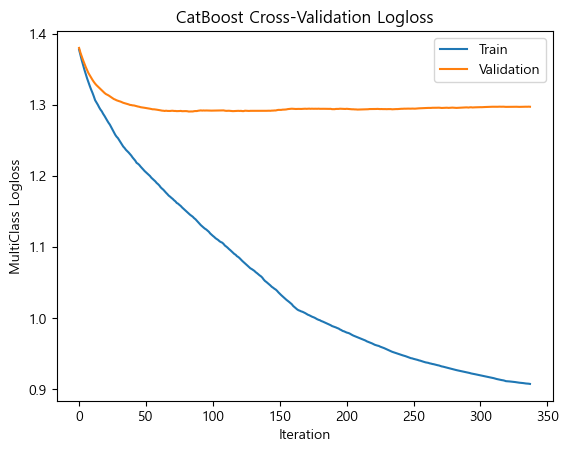

In [27]:
# 4. cv() 결과로 loss 곡선 그리기
train_loss = cv_results['train-MultiClass-mean']
val_loss = cv_results['test-MultiClass-mean']

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('MultiClass Logloss')
plt.title('CatBoost Cross-Validation Logloss')
plt.legend()
plt.show()


In [31]:
# 1. cv로 best_iteration 구하기
min_loss_idx = cv_results['test-MultiClass-mean'].idxmin()
best_iteration = min_loss_idx + 1   # 파이썬 index 보정(+1)
print('best_iteration:', best_iteration)

# 2. best_iteration으로 모델 최종 학습
final_model = CatBoostClassifier(
    iterations=best_iteration,
    learning_rate=0.01,
    loss_function='MultiClass',
    cat_features=cat_features,
    verbose=50
)
final_model.fit(X, y)


best_iteration: 83
0:	learn: 1.3846635	total: 41ms	remaining: 3.36s
50:	learn: 1.3176562	total: 4.7s	remaining: 2.95s
82:	learn: 1.2895785	total: 7.38s	remaining: 0us


In [32]:
# 1. '모름'인 행 선택
test_data = df[df['INCOME'] == '모름']

# 2. 예측에 사용될 X (INCOME 제거)
X = test_data.drop(['INCOME'], axis=1)

# 3. 예측 수행
pred_y = final_model.predict(X)

# 4. 인덱스 추출
target_index = X.index

# 5. 원래 df에 예측값 넣기
df.loc[target_index, 'INCOME'] = pred_y

In [34]:
df['INCOME'].unique()

array(['700만원 이상', '300만원 미만', '500이상700만원 미만', '300이상500만원 미만'],
      dtype=object)

# re-preprocessing data

In [38]:
#보간된 df를 jeju_df에 다시 저장
jeju_df = df
# 보간 후 '700만원 이상' 열 제외
jeju_df = jeju_df[jeju_df['INCOME']!='700만원 이상']

In [39]:
# 보간 확인
jeju_df['INCOME'].value_counts()

INCOME
500이상700만원 미만    256
300이상500만원 미만    239
300만원 미만         131
Name: count, dtype: int64

C:\Users\top\AppData\Local\Temp\ipykernel_13456\2303788261.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_labels, y=age_sizes, ax=axs[0, 1], palette='pastel')
C:\Users\top\AppData\Local\Temp\ipykernel_13456\2303788261.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='INCOME', data=jeju_df, ax=axs[1, 1], palette='pastel', order = income_order)


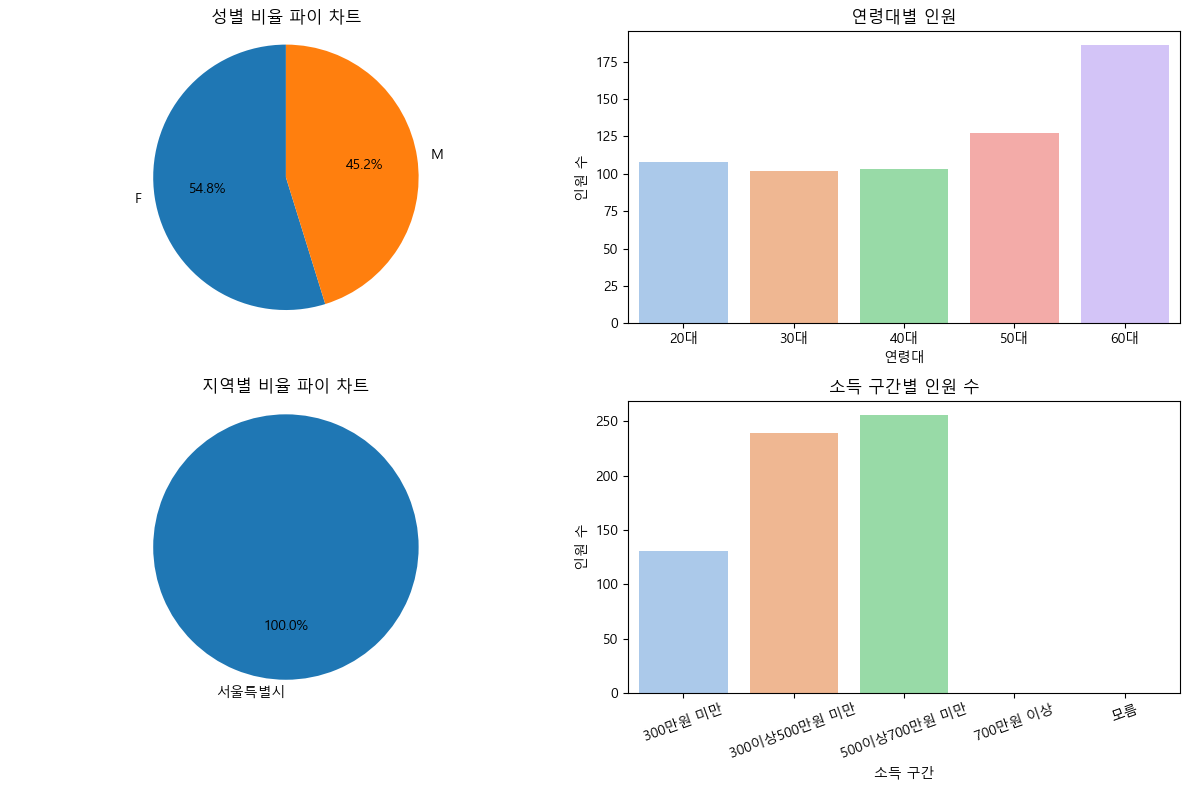

In [40]:
# 1. 성별 인원수 계산 (Pie Chart)
sex_counts = jeju_df['SEX'].value_counts()
sex_labels = sex_counts.index
sex_sizes = sex_counts.values

# 2. 연령대 인원수 계산 (Bar Plot)
age_counts = jeju_df['AGE'].value_counts().sort_index()  # 정렬
age_labels = age_counts.index
age_sizes = age_counts.values

# 3. 지역(AREA)별 인원수 계산 (Pie Chart)
area_counts = jeju_df['AREA'].value_counts()
area_labels = area_counts.index
area_sizes = area_counts.values

# 4. 소득(INCOME)별 인원수 (Countplot)
# (sns.countplot은 따로 value_counts 안 해도 되지만, 정렬이 필요하면 .sort_index() 활용)
# jeju_df['INCOME']이 카테고리형/문자형이라면 그대로 countplot 사용 가능

# 2x2 subplot 생성
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# [0, 0] 성별 파이 차트
axs[0, 0].pie(sex_sizes, labels=sex_labels, autopct='%.1f%%', startangle=90)
axs[0, 0].axis('equal')
axs[0, 0].set_title("성별 비율 파이 차트")

# [0, 1] 연령대별 Bar Plot
sns.barplot(x=age_labels, y=age_sizes, ax=axs[0, 1], palette='pastel')
axs[0, 1].set_title("연령대별 인원")
axs[0, 1].set_ylabel("인원 수")
axs[0, 1].set_xlabel("연령대")

# [1, 0] 지역별 파이 차트
axs[1, 0].pie(area_sizes, labels=area_labels, autopct='%.1f%%', startangle=90)
axs[1, 0].axis('equal')
axs[1, 0].set_title("지역별 비율 파이 차트")

# [1, 1] 소득구간 Countplot
income_order = ['300만원 미만', '300이상500만원 미만', '500이상700만원 미만', '700만원 이상', '모름']
sns.countplot(x='INCOME', data=jeju_df, ax=axs[1, 1], palette='pastel', order = income_order)
axs[1, 1].set_title("소득 구간별 인원 수")
axs[1, 1].set_xlabel("소득 구간")
axs[1, 1].set_ylabel("인원 수")
axs[1, 1].tick_params(axis='x', rotation=20)

# 자동 레이아웃 조정
plt.tight_layout()
plt.show();


# 보간 데이터 저장

In [41]:
jeju_df.to_csv('preprocessed data/interpolation_df.csv')